In [ ]:
%pip install numpy
%pip install matplotlib

134.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


140.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


145.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


151.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


157.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


162.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 5.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


176.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [23]:
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

2549.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Looking in indexes: https://download.pytorch.org/whl/nightly/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 5.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 5.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#checking if gpu is accessible on mac (optional)
import torch

# Check PyTorch version and GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"MPS (Metal) available: {torch.backends.mps.is_available()}")
print(f"MPS device available: {torch.backends.mps.is_built()}")

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Test computation on GPU
try:
    # Create tensors
    x = torch.rand(1000, 1000).to(device)
    y = torch.rand(1000, 1000).to(device)
    
    # Perform matrix multiplication
    z = torch.matmul(x, y)
    
    print("GPU computation successful!")
    print(f"Result shape: {z.shape}")
except Exception as e:
    print(f"Error: {e}")

PyTorch version: 2.6.0.dev20241115
MPS (Metal) available: True
MPS device available: True
Using device: mps
GPU computation successful!
Result shape: torch.Size([1000, 1000])


Using device: mps


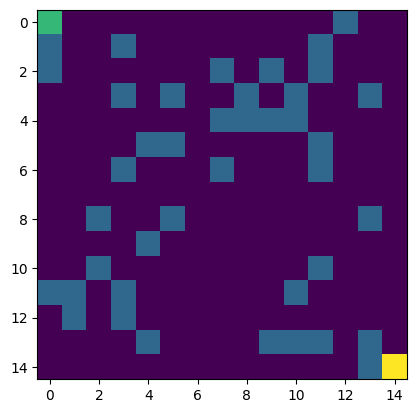

In [ ]:
import time
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

# Check for GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")#on apple silicon
#on windows: device=torch.device("cuda" if torch.backends.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Maze environment

class MazeEnv:
    def __init__(self, size=15, wall_density=0.2):
        self.size = size
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size - 1, self.size - 1]
        self.wall_density = wall_density
        self.maze = self._generate_maze()
        self.idle_counter = 0  # Track consecutive idle steps
        self.idle_penalty_threshold = 5  # Number of consecutive idle steps before penalty

    def reset(self):
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size - 1, self.size - 1]
        return self._get_state()

    def _generate_maze(self):
        # Initialize the maze with zeros
        maze = np.zeros((self.size, self.size))

        # Randomly place walls based on wall_density
        for _ in range(int(self.size * self.size * self.wall_density)):
            x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if [x, y] != self.agent_pos and [x, y] != self.goal_pos:
                maze[x, y] = 1

        # Ensure a valid path exists after placing walls
        self._ensure_path_exists(maze)
        return maze

    def _ensure_path_exists(self, maze):
        """
        Ensures there is a valid path from agent_pos to goal_pos by carving a DFS-based path if needed.
        """
        stack = [self.agent_pos]
        visited = set()
        visited.add(tuple(self.agent_pos))
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        # Attempt to find a valid path using DFS
        while stack:
            current = stack.pop()
            if current == self.goal_pos:
                return  # Path found, no further carving needed

            random.shuffle(directions)
            for direction in directions:
                next_pos = [current[0] + direction[0], current[1] + direction[1]]
                if 0 <= next_pos[0] < self.size and 0 <= next_pos[1] < self.size:
                    if tuple(next_pos) not in visited and maze[next_pos[0], next_pos[1]] == 0:
                        visited.add(tuple(next_pos))
                        stack.append(next_pos)

        # If no path is found, carve a direct path using DFS
        print("No valid path found, carving a direct path.")
        current = self.agent_pos
        visited = set()
        visited.add(tuple(current))
        stack = [current]

        while stack:
            current = stack[-1]
            if current == self.goal_pos:
                break

            random.shuffle(directions)
            path_extended = False
            for direction in directions:
                next_pos = [current[0] + direction[0], current[1] + direction[1]]
                if 0 <= next_pos[0] < self.size and 0 <= next_pos[1] < self.size and tuple(next_pos) not in visited:
                    # Carve the path
                    maze[next_pos[0], next_pos[1]] = 0
                    visited.add(tuple(next_pos))
                    stack.append(next_pos)
                    path_extended = True
                    break

            if not path_extended:
                stack.pop()  # Backtrack if no further path can be extended

        # Ensure the start and goal positions are open
        maze[self.agent_pos[0], self.agent_pos[1]] = 0
        maze[self.goal_pos[0], self.goal_pos[1]] = 0

    def _get_state(self):
        return self.agent_pos[0] * self.size + self.agent_pos[1]

    def step(self, action):
        reward = 0
        moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        next_pos = [self.agent_pos[0] + moves[action][0], self.agent_pos[1] + moves[action][1]]

        # Check if the move is within bounds and not a wall
        if 0 <= next_pos[0] < self.size and 0 <= next_pos[1] < self.size:
            if self.maze[next_pos[0], next_pos[1]] == 0:
                # Valid move
                if next_pos == self.agent_pos:
                    # Idle move (no change in position)
                    self.idle_counter += 1
                else:
                    # Reset idle counter if the agent moved
                    self.idle_counter = 0
                    self.agent_pos = next_pos
                reward = -1 # Step penalty

            else:
                reward= -10

        # Apply idle penalty if the agent has stayed idle for too long
        if self.idle_counter >= self.idle_penalty_threshold:
            reward -= 15  # Idle penalty
                   
        # Compute distance-based reward
        current_distance = np.linalg.norm(np.array(self.agent_pos) - np.array(self.goal_pos))
        next_distance = np.linalg.norm(np.array(next_pos) - np.array(self.goal_pos))

        if next_distance < current_distance:
            reward += 30  # Positive reward for getting closer
        else:
            reward -= 20  # Negative reward for moving away

        # Check if the agent has reached the goal
        done = False
        if self.agent_pos == self.goal_pos:
            reward = 90
            done = True

        return self._get_state(), reward, done, {}

    def render(self):
        grid = np.copy(self.maze)
        grid[self.agent_pos[0], self.agent_pos[1]] = 2
        grid[self.goal_pos[0], self.goal_pos[1]] = 3
        plt.imshow(grid, cmap='viridis')
        plt.show()

# Define the Q-network using PyTorch
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
state_size = 225
action_size = 4
alpha = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
batch_size = 32
memory_size = 25000
episodes = 500
save_interval = 10

# Initialize networks, optimizer, and memory
q_network = QNetwork(state_size, action_size).to(device)
target_network = QNetwork(state_size, action_size).to(device)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=alpha)
loss_fn = nn.MSELoss()

memory = deque(maxlen=memory_size)

# Initialize environment
env = MazeEnv(size=15, wall_density=0.2)
#env.render()

# Helper function to choose an action
def choose_action(state):
    state_one_hot = np.zeros(state_size)
    state_one_hot[state] = 1
    state_tensor = torch.tensor(state_one_hot, dtype=torch.float32).to(device)
    if random.random() < epsilon:
        return random.choice([0, 1, 2, 3])
    with torch.no_grad():
        q_values = q_network(state_tensor)
    return torch.argmax(q_values).item()

# Train the Q-network
def train_q_network():
    if len(memory) < batch_size:
        return

    minibatch = random.sample(memory, batch_size)
    states, targets = [], []

    for state, action, reward, next_state, done in minibatch:
        state_one_hot = np.zeros(state_size)
        state_one_hot[state] = 1
        next_state_one_hot = np.zeros(state_size)
        next_state_one_hot[next_state] = 1

        state_tensor = torch.tensor(state_one_hot, dtype=torch.float32).to(device)
        next_state_tensor = torch.tensor(next_state_one_hot, dtype=torch.float32).to(device)

        with torch.no_grad():
            target_q_values = target_network(next_state_tensor)
            max_next_q_value = torch.max(target_q_values).item()

        target = reward + (gamma * max_next_q_value * (1 - done))
        target_q_values = q_network(state_tensor)
        target_q_values[action] = target

        states.append(state_tensor)
        targets.append(target_q_values)

    states = torch.stack(states)
    targets = torch.stack(targets)
    optimizer.zero_grad()
    output = q_network(states)
    loss = loss_fn(output, targets)
    loss.backward()
    optimizer.step()

env.render()

In [ ]:
# Main training loop

model_path = f'non_idle_q_network_torch.pt'

map_fixed_for_episodes = 20  # Number of episodes to keep the same map


for episode in range(episodes):

    state = env.reset()
    if(episodes % map_fixed_for_episodes==0 and episodes!=0):
        env=MazeEnv()
    done = False
    total_reward = 0
    while not done:
        # env.render()
        action = choose_action(state)
        next_state, reward, done, _ = env.step(action)

        # Store experience in memory
        memory.append((state, action, reward, next_state, done))

        # Train the Q-network
        train_q_network()
        
        # clear_output(wait=True)
        state = next_state
        total_reward += reward


    epsilon = max(epsilon_min, epsilon * epsilon_decay)
  
    # Save model every 'save_interval' episodes
    if episode % save_interval == 0:
        torch.save(q_network.state_dict(), model_path)


In [5]:
# Testing
test_episodes = 1  # Number of test episodes
print("Starting Testing Phase...")

model_path = f'non_idle_q_network_torch.pt'
q_network_test = QNetwork(state_size, action_size).to(device)


Starting Testing Phase...


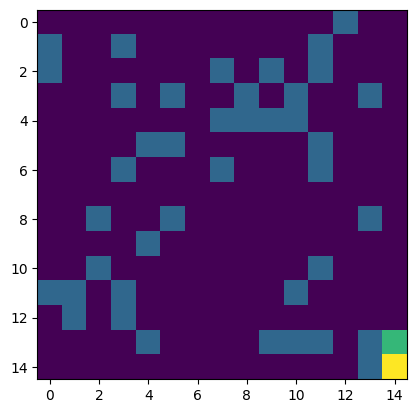

In [10]:
try:
    q_network_test.load_state_dict(torch.load(model_path))
    print("Model loaded successfully for testing.")
except Exception as e:
    print(f"Error loading model: {e}")

def choose_action_test(state):
    state_one_hot = np.zeros(state_size)
    state_one_hot[state] = 1
    state_tensor = torch.tensor(state_one_hot, dtype=torch.float32).to(device)
    if random.random() < 0.5:
        return random.choice([0,1,2,3])
    with torch.no_grad():
        q_values = q_network_test(state_tensor)
    return torch.argmax(q_values).item()

for episode in range(test_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    repetitive_action_count = 0
    last_action = -1
    while not done:
        env.render()
        action = choose_action_test(state)
        
        if action == last_action:
            repetitive_action_count += 1
        else:
            repetitive_action_count = 0

        if repetitive_action_count > 5:  #If the same action is repeated for too long
            ls=[0,1,2,3]
            ls=[x for x in ls if x!=action]
            action = random.choice(ls)

        last_action = action

        next_state, reward, done, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        clear_output(wait=True)